## Titanic - Machine Learning from Disaster

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [31]:
data = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
gender_submission = pd.read_csv('dataset/gender_submission.csv')

### Explore the Train Data

Problem Statement: it is to build a predictive model that identifies key factors associated with survival on the Titanic. I aim to explore how variables such as age, gender, class, fare, and family connections influence the likelihood of survival. It will not only predict survival outcomes but also understand the demographic and socio-economic characteristics that were most likely to increase survival chances.

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(data.shape)
print(test.shape)

(891, 12)
(418, 11)


### Data Preprocessing

In [7]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
data.duplicated().sum()

0

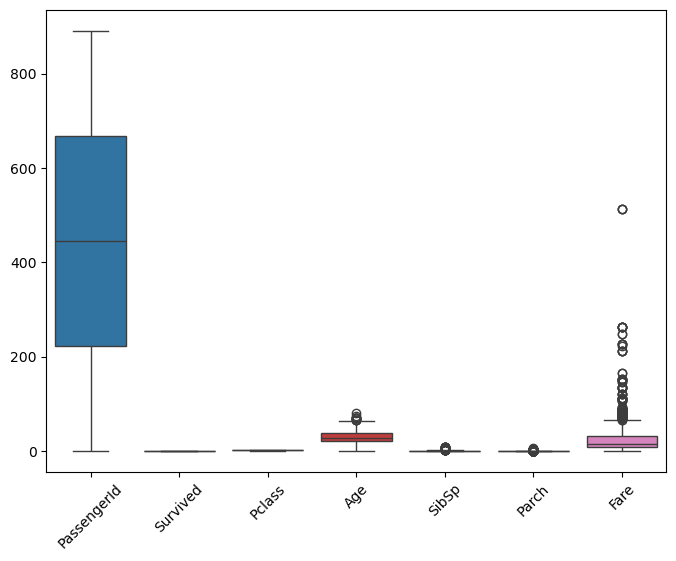

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data)
plt.xticks(rotation=45)
plt.show()

In [10]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

numerical_cols = data.select_dtypes(include=['number']).columns
for col in numerical_cols:
    outliers = detect_outliers_iqr(data, col)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in PassengerId: 0
Outliers in Survived: 0
Outliers in Pclass: 0
Outliers in Age: 11
Outliers in SibSp: 46
Outliers in Parch: 213
Outliers in Fare: 116


In [11]:
data['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [12]:
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

Observation: Missing values from age are filled in with the median age within each Pclass as there are outliers. Imputing Age by Pclass is more nuanced approach compared to using a global median imputation. Fractional age is kept in case it affected to survival of parents.

In [13]:
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [14]:
data.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

Observation: 
- Since there are high number, 687 of 891, NaNs in Cabin, and a lot of values are mixed and inconsistent, Cabin column is dropped.
- Name and Ticket columns are dropped as they are not meaningful patterns fo survival.


In [15]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [16]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data.isnull().sum()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24336\3631949386.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

Observation: The most common value can be a reasonable guess for two missing values.

In [17]:
data['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [18]:
data['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [19]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1  # +1 for self

# Create 'IsAlone' feature
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [20]:
df =  data.drop(['SibSp', 'Parch'], axis=1).copy()
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,1,0,3,male,22.0,7.2500,S,2,0
1,2,1,1,female,38.0,71.2833,C,2,0
2,3,1,3,female,26.0,7.9250,S,1,1
3,4,1,1,female,35.0,53.1000,S,2,0
4,5,0,3,male,35.0,8.0500,S,1,1


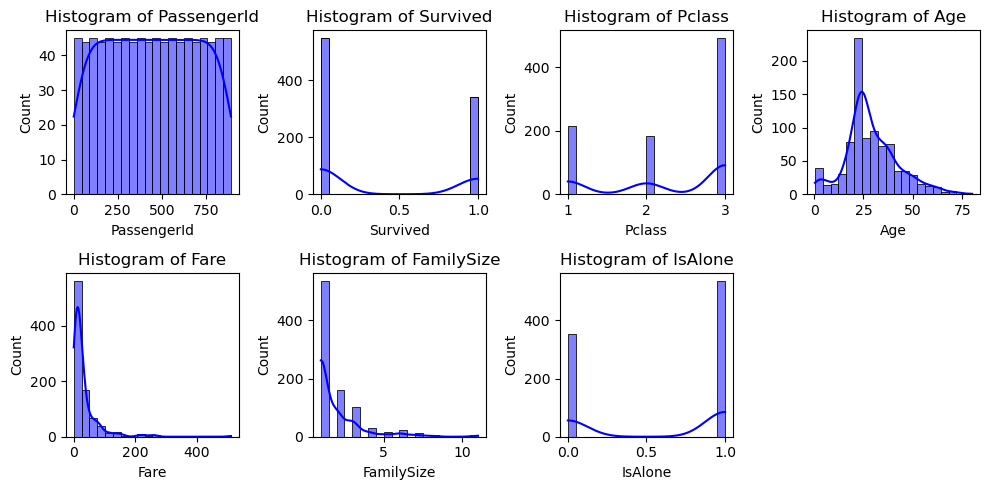

In [21]:
numerical_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(10,5))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

Observation: In titanic, it seems the majority of passengers being in their 20s. Younger passengers could have had different survival chances compared to older adults. This could be useful to anlyze by looking at the survival rates for different age groups.

Most passengers had no siblings, spouse, parents, or children. If family members were prioritized for lifeboat access or rescue, the survival rate could have been different. It coulld analyze how the rate differ for solo travelers versus families.

A lot of passengers paid less than $100 and there were much more people in 3rd/lower pclass. Lower fares generally correspond to lower class tickets.

### Exploratory Data Analysis (EDA)

In [22]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208,1.904602,0.602694
std,257.353842,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429,1.613459,0.489615
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000


In [23]:
# def family_group(size):
#     if size == 1:
#         return 'Alone'
#     elif size <= 4:
#         return 'Small'
#     else:
#         return 'Large'

# df['FamilySize'] = df['FamilySize'].apply(family_group)

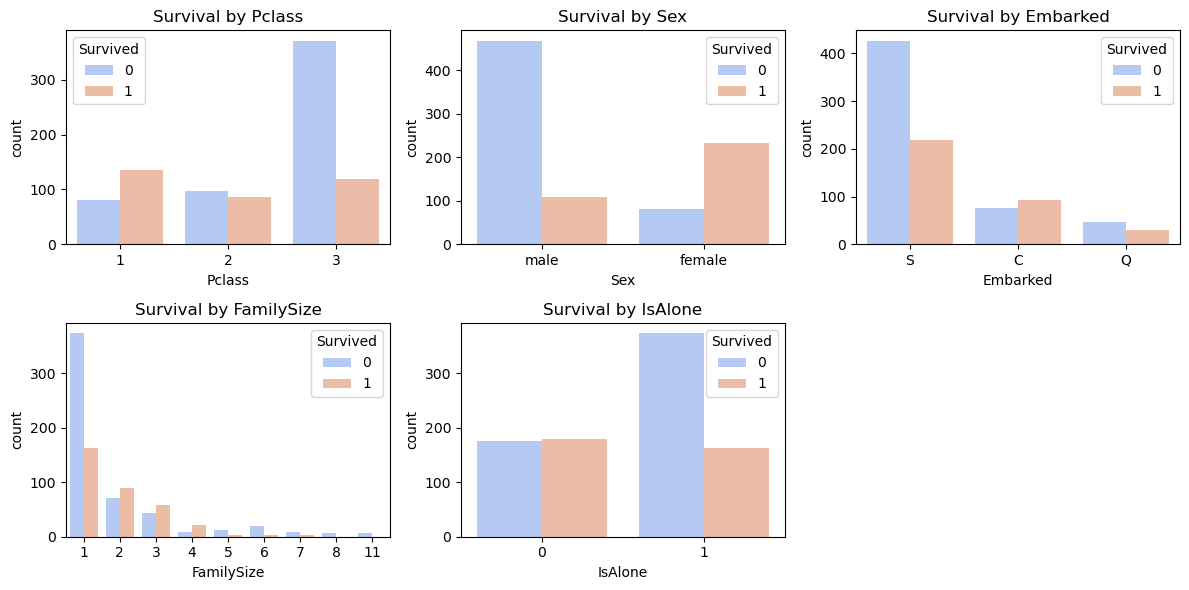

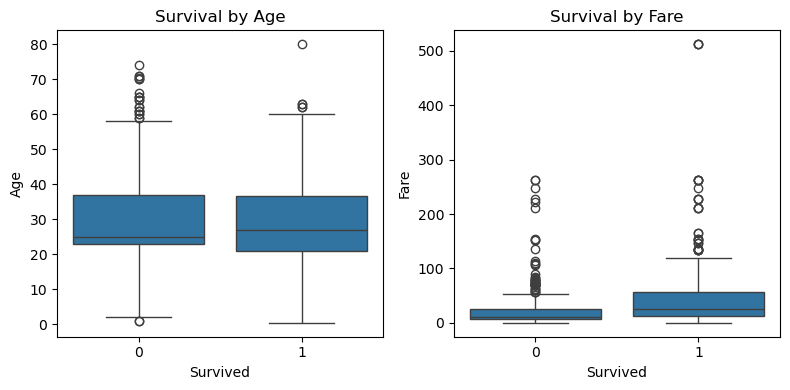

In [24]:
# List of categorical columns
categorical_columns = ['Pclass', 'Sex', 'Embarked', 'FamilySize', 'IsAlone']

# Count plots for categorical features
plt.figure(figsize=(12, 6))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=column, hue='Survived', data=df, palette='coolwarm')
    plt.title(f'Survival by {column}')
    plt.tight_layout()
plt.show()

# Box plots for numerical features like 'Age' and 'Fare'
plt.figure(figsize=(8, 4))

# Age distribution by Survived
plt.subplot(1, 2, 1)
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Survival by Age')

# Fare distribution by Survived
plt.subplot(1, 2, 2)
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Survival by Fare')

plt.tight_layout()
plt.show()


Observation:
- Pclass: Passengers in 1 class had the highest survival rate, while those in class 3 had the lowest survival rate, meaning highest number of deaths.

- Sex: The number of male who didn't survive is significantly higher than Female.

- Embarked: Most passengers embarked from Southampton, showing both survival and non-survival counts are higher.

- FamilySize, IsAlone: Passengers traveling alone had the lowest survival rate, at the same time, highest survival rate compared to those who have more than one famillysize. Large families also show lower survival rates.

- Age: Most of the older adults (over 60) had a very low survival rate.

- Fare: Passengers who paid higher fares were more likely to survive.


SURVIVAL RATE??

In [25]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
FamilySize     0
IsAlone        0
dtype: int64

In [26]:
# Label encoding for Sex
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)

# # Label encoding for FamilySize
# df['FamilySize'] = df['FamilySize'].map({'Alone': 1, 'Small': 2, 'Large': 3}).astype(int)

# One-hot encoding for Embarked
df = pd.get_dummies(df, columns=['Embarked']).astype(int)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22,7,2,0,0,0,1
1,2,1,1,1,38,71,2,0,1,0,0
2,3,1,3,1,26,7,1,1,0,0,1
3,4,1,1,1,35,53,2,0,0,0,1
4,5,0,3,0,35,8,1,1,0,0,1


In [27]:
corr = df.select_dtypes(include=['number']).corr()
corr

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.035948,0.012668,-0.040143,0.057462,-0.001205,-0.033606,0.022204
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.047266,0.257482,0.016639,-0.203367,0.168240,0.003650,-0.149683
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.408557,-0.550553,0.065997,0.135207,-0.243292,0.221009,0.074053
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.078020,0.182331,0.200988,-0.303646,0.082853,0.074115,-0.119224
Age,0.035948,-0.047266,-0.408557,-0.078020,1.000000,0.124239,-0.251898,0.165523,0.040188,-0.081692,0.016202
Fare,0.012668,0.257482,-0.550553,0.182331,0.124239,1.000000,0.217052,-0.272355,0.269165,-0.118319,-0.161341
FamilySize,-0.040143,0.016639,0.065997,0.200988,-0.251898,0.217052,1.000000,-0.690922,-0.046215,-0.058592,0.077359
IsAlone,0.057462,-0.203367,0.135207,-0.303646,0.165523,-0.272355,-0.690922,1.000000,-0.095298,0.086464,0.029074
Embarked_C,-0.001205,0.168240,-0.243292,0.082853,0.040188,0.269165,-0.046215,-0.095298,1.000000,-0.148258,-0.782742
Embarked_Q,-0.033606,0.003650,0.221009,0.074115,-0.081692,-0.118319,-0.058592,0.086464,-0.148258,1.000000,-0.499421


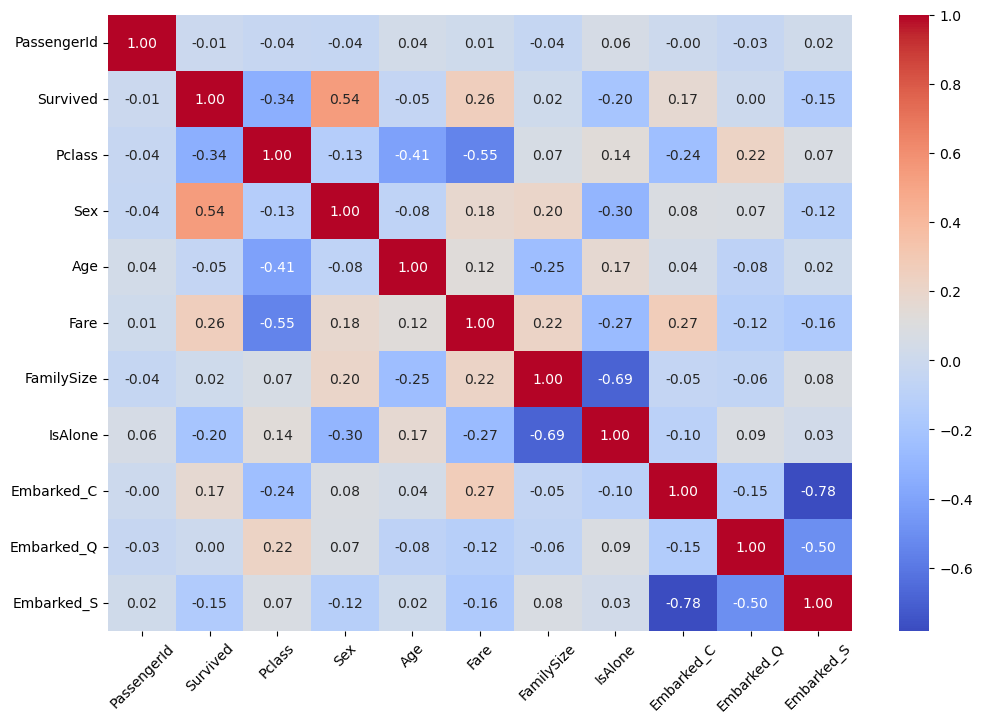

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.show()

In [29]:
survived_corr = corr['Survived'].sort_values(ascending=False)
survived_corr[1:]

Sex            0.543351
Fare           0.257482
Embarked_C     0.168240
FamilySize     0.016639
Embarked_Q     0.003650
PassengerId   -0.005007
Age           -0.047266
Embarked_S    -0.149683
IsAlone       -0.203367
Pclass        -0.338481
Name: Survived, dtype: float64

Observation:
- Sex: 0.543 correlation
    
    Strongest predictor. Female significantly increased survival chances.
- Pclass: -0.33 correlation
    
    Pclass 3 was associated with lower survival.
- IsAlone: -0.203 correlation
    
    Being alone reduced survival chances.
- Fare: 0.257 correlation
    
    Higher fare generally meant higher survival probability.

In [33]:
passenger_ids = df['PassengerId']
df.drop(columns='PassengerId', inplace=True)

Observation: PassengerId has no meaningful relationship with the target 'Survived' and there is no predictive value, so it is dropped.

### Model Training

In [37]:
X = df.drop('Survived', axis=1)
Y = df['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Evaluate on Train Data

### Test Data